## Land Cover Mapping

Multi-class classification problem using Unet.


## Dataset

Input data are RGB satellite images. And output are images of land cover type. There are 4 land cover types as below,
- Pixel value 0: background class
- Pixel value 1: building class
- Pixel value 2: vegetation/forest class
- Pixel value 3: water class

In [ ]:
!pip install --upgrade tensorflow


In [ ]:
# import required libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from tensorflow.keras import Model
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

In [ ]:
# connect google drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# set the working directory
import os
os.chdir(r'/content/gdrive/MyDrive/Land_Cover_Land_Use')

In [ ]:
# data is already randomized and split in to training / test sets. So we can go ahead and use them as it is.
x_train = np.load('x_train.npy').astype('float32')
y_train= np.load('y_train.npy').astype('float32')
x_test = np.load('x_test.npy').astype('float32')
y_test = np.load('y_test.npy').astype('float32')

print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("y_test shape", x_test.shape)
print("y_test shape", y_test.shape)

x_train shape (70, 128, 128, 3)
y_train shape (70, 128, 128, 1)
y_test shape (30, 128, 128, 3)
y_test shape (30, 128, 128, 1)


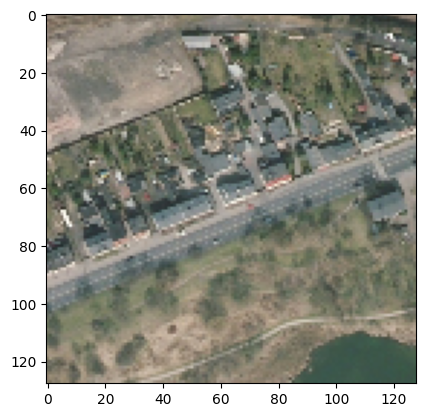

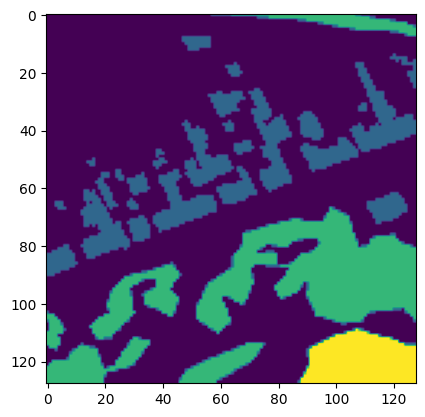

In [ ]:
# Let's plot a sample input RGB image and output image with land cover

plt.imshow(x_test[12,:,:,:].astype('uint8'))
plt.show()

plt.imshow(y_test[12,:,:,0].astype('uint8'))
plt.show()

Since land cover data include classes, let's perform one-hot encoding first.

In [ ]:
'''one-hot encoding'''

from tensorflow.keras.utils import to_categorical

y_train_1hot = to_categorical(y_train)
y_test_1hot = to_categorical(y_test)

y_train_1hot.shape

(70, 128, 128, 4)

Now, let's define, fit, predict and validate U-Net model for land cover mapping. Here in this example also, we will use same U-Net architecture as in our last example (building mapping). Only different here use of __*softmax*__ activation in the last layer and use of __*cross-entropy*__ loss, because this is a multi-class classification problem.

In [ ]:
y_train_1hot

## Model development (Unet)

In [ ]:
x_in = Input(shape=(128, 128, 3))

'''Encoder'''
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)

'''Use 1 by 1 Convolution to get desired output bands'''
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(4, (1, 1), activation='softmax', padding='same')(x_temp)

model = Model(inputs=x_in, outputs=x_out)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 128, 128, 32)         896       ['input_3[0][0]']             
                                                                                                  
 dropout_8 (Dropout)         (None, 128, 128, 32)         0         ['conv2d_11[0][0]']           
                                                                                                  
 conv2d_12 (Conv2D)          (None, 128, 128, 32)         9248      ['dropout_8[0][0]']           
                                                                                            

In [ ]:
history = model.fit(x_train, y_train_1hot, validation_data=(x_test, y_test_1hot), epochs=250, batch_size=8, verbose=1)

Epoch 1/250
9/9 [==============================] - 6s 102ms/step - loss: 2.0951 - acc: 0.5846 - val_loss: 1.1797 - val_acc: 0.4522
Epoch 2/250
9/9 [==============================] - 0s 46ms/step - loss: 0.9615 - acc: 0.6913 - val_loss: 0.9589 - val_acc: 0.6810
Epoch 3/250
9/9 [==============================] - 0s 47ms/step - loss: 0.8999 - acc: 0.7164 - val_loss: 0.9471 - val_acc: 0.6812
Epoch 4/250
9/9 [==============================] - 0s 49ms/step - loss: 0.8635 - acc: 0.7201 - val_loss: 0.9279 - val_acc: 0.6813
Epoch 5/250
9/9 [==============================] - 0s 49ms/step - loss: 0.8839 - acc: 0.7203 - val_loss: 1.1476 - val_acc: 0.6813
Epoch 6/250
9/9 [==============================] - 0s 51ms/step - loss: 0.9121 - acc: 0.7203 - val_loss: 0.9281 - val_acc: 0.6813
Epoch 7/250
9/9 [==============================] - 0s 51ms/step - loss: 0.8732 - acc: 0.7204 - val_loss: 0.9483 - val_acc: 0.6813
Epoch 8/250
9/9 [==============================] - 1s 63ms/step - loss: 0.8341 - acc: 0.7

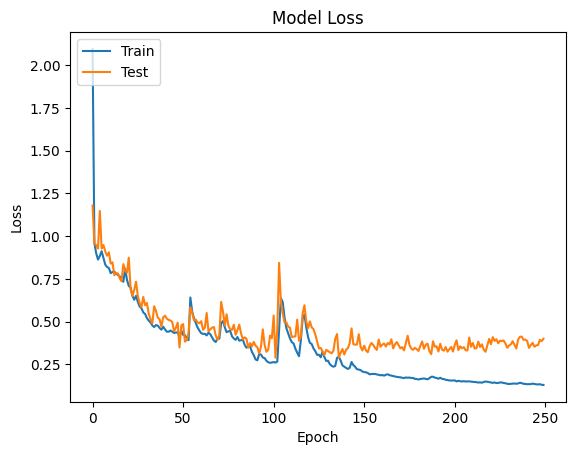

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Prediction

1/1 [==============================] - 2s 2s/step
(30, 128, 128)


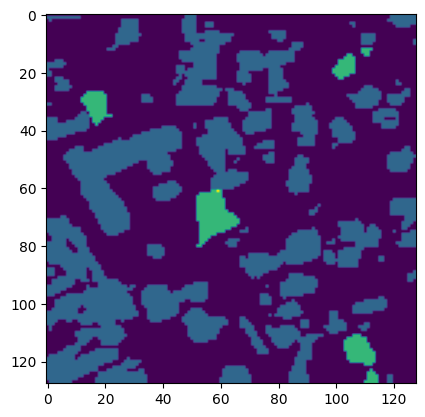

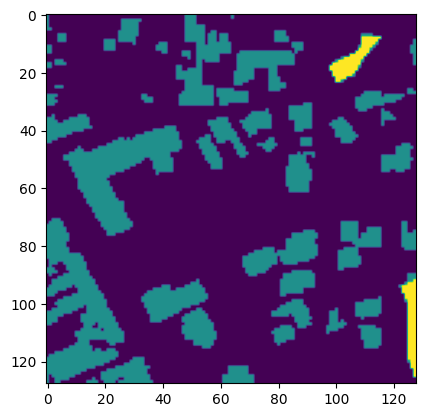

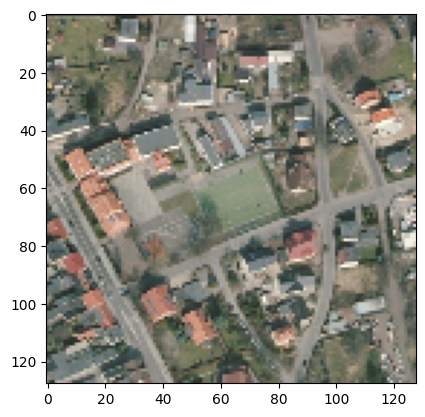

In [ ]:
'''Prediction over the test dataset'''
pred_test = model.predict(x_test)

pred_test = np.argmax(pred_test, axis=-1)
print(pred_test.shape)

#let's compare sample predicted and actual land cover image with input RGB image

plt.imshow(pred_test[15, :, :])
plt.show()
plt.imshow(y_test[15, :, :, 0])
plt.show()
plt.imshow(x_test[15,:,:,:].astype('uint8'))
plt.show()

This is not an operational model with high accuracy. But with more layers and with more data, we can develop this architecture in to an operational model with high accuracy.